In [1]:
%load_ext autoreload
%matplotlib ipympl
import networkx as nx
import matplotlib.pyplot as plt
import bpy
from bpy.types import bpy_prop_array
import mathutils
import numpy as np

In [2]:
import sys
sys.path.append('/Users/orenm/BlenderShaderProject/project_files/')

In [3]:
%autoreload 2
from Logic.node_readers_writers import *

In [138]:
# add W and all seed values
# make a dict to find them

In [141]:
self = NetworkManager()
self.initialize_network()
self.generate_random_network(n_additions=4)

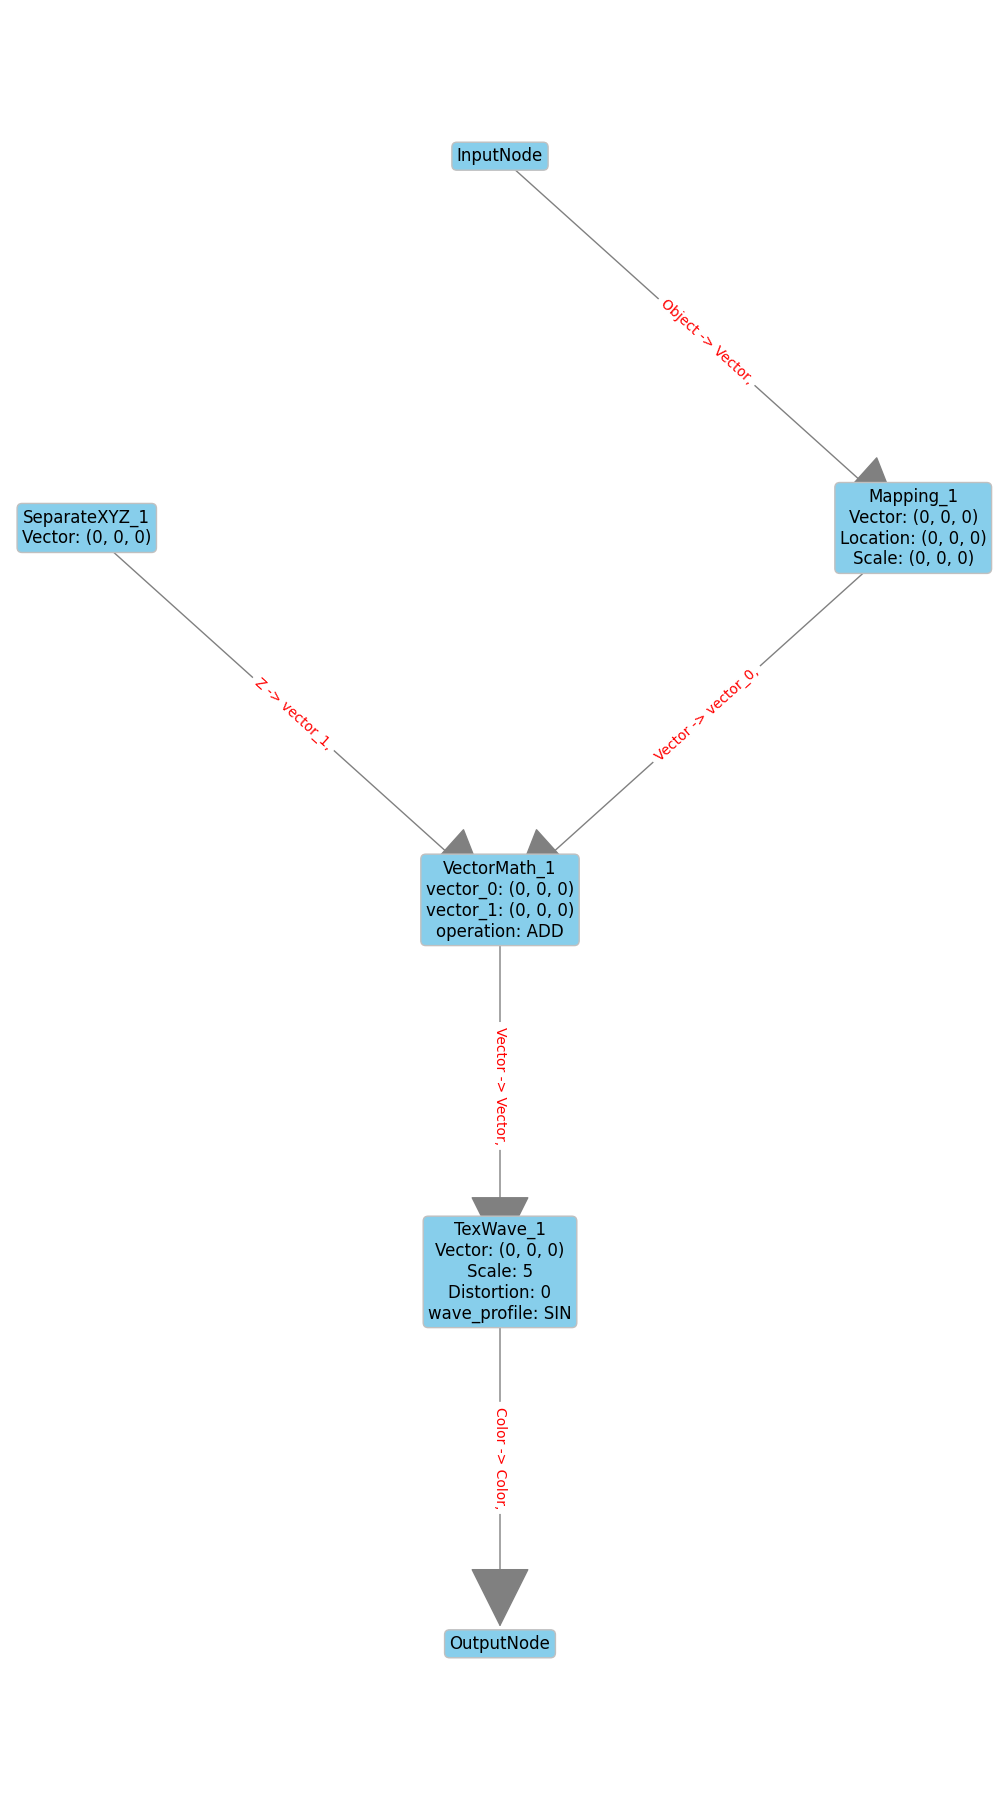

In [142]:
self.draw_network()